In [54]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.biases = [np.zeros((1, layers[i+1])) for i in range(len(layers)-1)]
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward_pass(self, X):
        activations = [X]
        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            activations.append(self.sigmoid(z))
        return activations
    
    def backward_pass(self, X, Y, activations):
        deltas = [(activations[-1] - Y) * self.sigmoid_derivative(activations[-1])]
        for i in range(len(self.layers) - 2, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.sigmoid_derivative(activations[i])
            deltas.insert(0, delta)
        return deltas
    
    
    def compute_gradients(self, activations, deltas):
        gradients_weights = [np.dot(activations[i].T, deltas[i]) for i in range(len(self.layers) - 1)]
        gradients_biases = [np.sum(deltas[i], axis=0) for i in range(len(self.layers) - 1)]
        return gradients_weights, gradients_biases
    
    def update_weights(self, gradients_weights, gradients_biases, learning_rate):
        self.weights = [w - learning_rate * gw for w, gw in zip(self.weights, gradients_weights)]
        self.biases = [b - learning_rate * gb for b, gb in zip(self.biases, gradients_biases)]
    
    def train(self, X, Y, learning_rate, lam, max_iterations, epsilon):
        for iteration in range(max_iterations):
            activations = self.forward_pass(X)
            deltas = self.backward_pass(X, Y, activations)
            gradients_weights, gradients_biases = self.compute_gradients(activations, deltas)
            self.update_weights(gradients_weights, gradients_biases, learning_rate)
            # Compute cost function
            J = np.mean(np.square(activations[-1] - Y))
            #print(f"Iteration {iteration+1}, Cost: {J}")
            # Check for convergence
            if J < epsilon:
                print(f"Converged at cost :{J} while Epsilon:{epsilon} and Iteration: {iteration+1} ")
                return J
        return J
            

    def accuracy(self, y_true, y_pred):
        correct = np.sum(np.all(y_true == y_pred, axis=1))
        return correct / len(y_true)


    def f1_score(self, y_true, y_pred):
        tp = np.sum(np.logical_and(y_true, y_pred))
        fp = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
        fn = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))
        precision = (tp) / (tp + fp) if (tp + fp) > 0 else 0
        recall = (tp) / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        return f1


    def evaluate(self, X_test, y_test, J):
        activations = self.forward_pass(X_test)[-1]
        y_pred = (activations > 0.5).astype(int)
        acc = self.accuracy(y_test, y_pred)
        f1 = self.f1_score(y_test, y_pred)
        return J, acc, f1
    
    def k_fold_cross_validation(X, y, architectures, regularization_params, learning_rate, max_iterations, epsilon):
        results_accuracy = {}
        results_f1_score = {}
        results_J_cost = {}
        
        num_splits = 10
        fold_size = len(X) // num_splits

        for arch in architectures:
            for lam in regularization_params:
                accuracy_list = []
                f1_score_list = []
                J_list = []
                
                for i in range(num_splits):
                    start = i * fold_size
                    end = (i + 1) * fold_size
                    
                    X_train = pd.concat([X[:start], X[end:]])
                    y_train = np.concatenate([y[:start], y[end:]])
                    X_test = X[start:end]
                    y_test = y[start:end]


                    model = NeuralNetwork(arch)
                    J = model.train(X_train, y_train, learning_rate=learning_rate, lam=lam, max_iterations=max_iterations, epsilon=epsilon)
                    J, accuracy, f1_score = model.evaluate(X_test, y_test, J)
                    accuracy_list.append(accuracy)
                    f1_score_list.append(f1_score)
                    J_list.append(J)

                mean_accuracy = np.mean(accuracy_list)
                mean_f1_score = np.mean(f1_score_list)
                mean_J_cost   = np.mean(J_list)

                results_accuracy[(str(arch), lam)] = mean_accuracy
                results_f1_score[(str(arch), lam)] = mean_f1_score
                results_J_cost[(str(arch), lam)] = mean_J_cost

        return results_accuracy, results_f1_score, results_J_cost


df_titanic = pd.read_csv("/Users/noshitha/Downloads/final_project/titanic.csv", delimiter=",")

# Shuffle the dataset
df_titanic_shuffle = shuffle(df_titanic)

# Split the dataset into features and target variable
X_df = df_titanic_shuffle.drop(columns=['Survived'])

# Convert categorical columns to categorical data type
categorical_cols = ['Pclass', 'Siblings/Spouses Aboard', 'Parents/Children Aboard']
for col in categorical_cols:
    X_df[col] = X_df[col].astype('category')

# Encoding on X:
X_categorical = pd.get_dummies(X_df[['Pclass', 'Sex', 'Siblings/Spouses Aboard', 'Parents/Children Aboard']])
X_categorical['Name'] = X_df['Name']  # Add Name column to X_categorical
X_numerical = X_df[['Name', 'Age', 'Fare']]

X_numerical_normal = X_numerical[['Age', 'Fare']]
mean = np.mean(X_numerical_normal, axis=0)
std = np.std(X_numerical_normal, axis=0)
X_numerical_normalized = (X_numerical_normal - mean) / std

# Combine normalized numerical columns with categorical columns
X_combined = pd.concat([X_numerical[['Name']], X_numerical_normalized], axis=1)

merged_df = pd.merge(X_categorical, X_combined, on='Name')
X = merged_df.drop(columns=['Name'])
y = df_titanic_shuffle['Survived']

# Normalize data
y_resized = y.values.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the target variable
y_encoded = encoder.fit_transform(y_resized)

# Define model architectures and regularization parameters
architectures = [ 
      [X.shape[1], 16, y_encoded.shape[1]],
      [X.shape[1], 32, y_encoded.shape[1]],
      [X.shape[1], 16, 8, y_encoded.shape[1]]
]

regularization_params = [0.01, 0.10, 0.25, 0.50, 0.75] 


# Initialize lists to store results
results_accuracy = {}
results_f1_score = {}
results_J_cost = {}

# Perform stratified k-fold cross-validation
results_accuracy, results_f1_score, results_J_cost = NeuralNetwork.k_fold_cross_validation(X, y_encoded, architectures, regularization_params, learning_rate=0.5 , max_iterations=2500, epsilon=0.005)

# Convert the results into a DataFrame for tabular representation
accuracy_df = pd.DataFrame(list(results_accuracy.items()), columns=['Architecture, Lambda', 'Mean Accuracy'])
f1_score_df = pd.DataFrame(list(results_f1_score.items()), columns=['Architecture, Lambda', 'Mean F1 Score'])
J_cost_df = pd.DataFrame(list(results_J_cost.items()), columns=['Architecture, Lambda', 'Mean J Cost'])

print("Mean Accuracy Results for titanic DATASET:")
print(accuracy_df)
print("\nMean F1 Score Results for titanic DATASET:")
print(f1_score_df)

Mean Accuracy Results for titanic DATASET:
      Architecture, Lambda  Mean Accuracy
0      ([21, 16, 2], 0.01)       0.796591
1       ([21, 16, 2], 0.1)       0.806818
2      ([21, 16, 2], 0.25)       0.798864
3       ([21, 16, 2], 0.5)       0.806818
4      ([21, 16, 2], 0.75)       0.792045
5      ([21, 32, 2], 0.01)       0.811364
6       ([21, 32, 2], 0.1)       0.796591
7      ([21, 32, 2], 0.25)       0.803409
8       ([21, 32, 2], 0.5)       0.804545
9      ([21, 32, 2], 0.75)       0.798864
10  ([21, 16, 8, 2], 0.01)       0.795455
11   ([21, 16, 8, 2], 0.1)       0.794318
12  ([21, 16, 8, 2], 0.25)       0.801136
13   ([21, 16, 8, 2], 0.5)       0.801136
14  ([21, 16, 8, 2], 0.75)       0.794318

Mean F1 Score Results for titanic DATASET:
      Architecture, Lambda  Mean F1 Score
0      ([21, 16, 2], 0.01)       0.798600
1       ([21, 16, 2], 0.1)       0.806818
2      ([21, 16, 2], 0.25)       0.800239
3       ([21, 16, 2], 0.5)       0.806818
4      ([21, 16, 2], 0.75)     

In [47]:
# Merge accuracy and f1_score DataFrames on 'Architecture, Lambda'
merged_df = pd.merge(accuracy_df, f1_score_df, on='Architecture, Lambda')

# Merge the merged DataFrame with J_cost_df on 'Architecture, Lambda'
final_df = pd.merge(merged_df, J_cost_df, on='Architecture, Lambda')

# Rename columns for clarity
merged_df.columns = ['Architecture, Lambda', 'Mean Accuracy', 'Mean F1 Score']
merged_df

,"Architecture, Lambda",Mean Accuracy,Mean F1 Score
0,"([21, 16, 2], 0.01)",0.815909,0.816999
1,"([21, 16, 2], 0.1)",0.810227,0.814172
2,"([21, 16, 2], 0.25)",0.822727,0.826321
3,"([21, 16, 2], 0.5)",0.801136,0.804181
4,"([21, 16, 2], 0.75)",0.802273,0.804069
5,"([21, 16, 8, 2], 0.01)",0.806818,0.808859
6,"([21, 16, 8, 2], 0.1)",0.810227,0.810708
7,"([21, 16, 8, 2], 0.25)",0.802273,0.802273
8,"([21, 16, 8, 2], 0.5)",0.809091,0.811195
9,"([21, 16, 8, 2], 0.75)",0.811364,0.813102


In [77]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to generate mini-batches
def generate_mini_batches(X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    mini_batches = []
    shuffled_indices = np.random.permutation(num_samples)
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        mini_batches.append((X_shuffled[start_idx:end_idx], y_shuffled[start_idx:end_idx]))
    if num_samples % batch_size != 0:
        mini_batches.append((X_shuffled[num_batches*batch_size:], y_shuffled[num_batches*batch_size:]))
    return mini_batches


def train_mini_batch(X_train, y_train, model, learning_rate, batch_size, max_iterations, epsilon):
    training_errors = []
    for iteration in range(max_iterations):
        mini_batches = generate_mini_batches(X_train, y_train, batch_size)
        for mini_batch in mini_batches:
            X_mini_batch, y_mini_batch = mini_batch
            J = model.train(X_mini_batch, y_mini_batch, learning_rate=learning_rate, lam=0.01, max_iterations = 200, epsilon=epsilon)
        training_cost = np.mean(np.square(model.forward_pass(X_train)[-1] - y_train))  # Compute training cost
        training_errors.append(training_cost)
        print(f"Iteration {iteration+1}, Training Cost: {training_cost}")
        # Check for convergence
        if training_cost < epsilon:
            print(f"Converged at training cost :{training_cost} while Epsilon:{epsilon} ")
            break
    return training_errors

# Plot learning curve
def plot_learning_curve(training_errors, step_size):
    iterations = range(1, len(training_errors) + 1)
    plt.plot(iterations, training_errors, label='Training Error')
    plt.title('Learning Curve')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('J values')
    plt.xticks(np.arange(1, len(training_errors) + 1, step=step_size))
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define your neural network model and parameters
model = NeuralNetwork([X.shape[1], 32, y_encoded.shape[1]])  # Your desired architecture
learning_rate = 0.5
batch_size = 10
max_iterations = 200
epsilon = 0.005


# Standardize features
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_normalized = (X - mean) / std

# Train the model using mini-batch gradient descent
training_errors = train_mini_batch(X_normalized.to_numpy(), y_encoded, model, learning_rate, batch_size, max_iterations, epsilon)

Converged at cost :0.004913961355568203 while Epsilon:0.005 and Iteration: 78 
Converged at cost :0.004351982605160655 while Epsilon:0.005 and Iteration: 18 
Converged at cost :0.0010852064653451604 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004010906934521051 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004889424188817016 while Epsilon:0.005 and Iteration: 146 
Converged at cost :0.004440586886962968 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.0012036846490003192 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003161477704483982 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0038440878421737183 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0025264620385189 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004664276304054089 while Epsilon:0.005 and Iteration: 17 
Converged at cost :0.002005772194266194 while Epsilon:0.005 and Iteration: 2 
Converged at cost :8.671394964913415e-05 while Epsilon:0.0

Converged at cost :0.002134326175177235 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.002909115326590948 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0026684452897032624 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.00017360613045071244 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0027884202133738947 while Epsilon:0.005 and Iteration: 43 
Converged at cost :0.0031152588026192697 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004707939605161936 while Epsilon:0.005 and Iteration: 34 
Converged at cost :0.0014685601756546534 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.00395261247847273 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.004778725473080764 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0042596742177387695 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0028124307535181458 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00024126004322618105 while Eps

Converged at cost :0.003951341214200027 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.0038620344061933154 while Epsilon:0.005 and Iteration: 41 
Converged at cost :0.0035731310869756643 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.0017874171517695565 while Epsilon:0.005 and Iteration: 174 
Converged at cost :0.0030834621337000627 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.0016072204614946347 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0041726603915408925 while Epsilon:0.005 and Iteration: 61 
Converged at cost :0.0019085356284510365 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004251516153098621 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0037150501617014713 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.004052054572153526 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.004412826071273049 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.003201749098248012 while Epsi

Converged at cost :0.002923691363721871 while Epsilon:0.005 and Iteration: 160 
Converged at cost :0.0002625151518550825 while Epsilon:0.005 and Iteration: 34 
Converged at cost :0.0035342314333406065 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0039739595513143145 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.004102408994024566 while Epsilon:0.005 and Iteration: 18 
Converged at cost :0.004787123157893513 while Epsilon:0.005 and Iteration: 118 
Converged at cost :0.0041117003851450385 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.004876685226580515 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0033213728970925135 while Epsilon:0.005 and Iteration: 39 
Converged at cost :0.0006025069801043361 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0017399649722410599 while Epsilon:0.005 and Iteration: 57 
Converged at cost :0.004716546266104367 while Epsilon:0.005 and Iteration: 21 
Converged at cost :0.004245953063205689 while 

Converged at cost :0.0014348588858912967 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.001025027337199464 while Epsilon:0.005 and Iteration: 116 
Converged at cost :0.0028818962943337485 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.000849644452797329 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004842816472150335 while Epsilon:0.005 and Iteration: 7 
Converged at cost :6.284629694113535e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0007683188157548029 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.000263049307762446 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004505406514907819 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0026525581372761043 while Epsilon:0.005 and Iteration: 16 
Converged at cost :0.0031125098175417898 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004669090409742681 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.004755619694164577 while Epsilon

Converged at cost :0.0049257443037768 while Epsilon:0.005 and Iteration: 118 
Converged at cost :0.002334040258401703 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004712338458873376 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0019333203353663387 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.004688668558422841 while Epsilon:0.005 and Iteration: 159 
Converged at cost :0.00020952851418979285 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.000318708655231456 while Epsilon:0.005 and Iteration: 86 
Converged at cost :8.284478823286149e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0018339581418675254 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0022066174011712266 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0010906812536172956 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004869882930926431 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0037366443833446346 while Epsil

Converged at cost :0.0032578602981643305 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00011657775784066376 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003367708428912617 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003873613705279229 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0011565017943347185 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.00487601755595532 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0007698283864903683 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0006285628169965264 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0026716167382513133 while Epsilon:0.005 and Iteration: 107 
Converged at cost :0.002827322702366035 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0001131343084519981 while Epsilon:0.005 and Iteration: 1 
Converged at cost :2.1068053031858055e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :6.316730202007604e-05 while Epsil

Converged at cost :0.002705661030877478 while Epsilon:0.005 and Iteration: 28 
Converged at cost :0.002646025151481562 while Epsilon:0.005 and Iteration: 2 
Converged at cost :8.202182008801581e-05 while Epsilon:0.005 and Iteration: 47 
Converged at cost :0.0038970760764786274 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00173865757224131 while Epsilon:0.005 and Iteration: 85 
Converged at cost :0.004852773031994779 while Epsilon:0.005 and Iteration: 5 
Converged at cost :1.0240159128407712e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002230589311308072 while Epsilon:0.005 and Iteration: 3 
Converged at cost :9.632878619729202e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00032557516693352434 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0021877854519669086 while Epsilon:0.005 and Iteration: 163 
Converged at cost :5.005144323648751e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00016393994080331374 while Eps

Converged at cost :0.0032991912487262904 while Epsilon:0.005 and Iteration: 15 
Converged at cost :3.5764277245884174e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004899448598690236 while Epsilon:0.005 and Iteration: 127 
Converged at cost :0.0013022347808430714 while Epsilon:0.005 and Iteration: 42 
Converged at cost :0.0006224446958944515 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0008070206963824353 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0002665450447246768 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0009706823622757108 while Epsilon:0.005 and Iteration: 26 
Converged at cost :0.003897042877135719 while Epsilon:0.005 and Iteration: 180 
Converged at cost :0.0028552608583791183 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.004724332581672827 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.003861935977858627 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004630130969380619 while E

Converged at cost :0.003634900602790661 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0037392758368400086 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.003908884734430409 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0012643889643976906 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003532056453174071 while Epsilon:0.005 and Iteration: 65 
Converged at cost :0.00015256709047305563 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0002742255860544351 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003976803916622429 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0030206144158339506 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0049295094952658105 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0018895290091634578 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004932993560733178 while Epsilon:0.005 and Iteration: 139 
Converged at cost :0.004489576378445264 while Epsilo

Converged at cost :0.00046004437481247777 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0002952087968578343 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004784074028463274 while Epsilon:0.005 and Iteration: 52 
Converged at cost :0.00032646291752484616 while Epsilon:0.005 and Iteration: 79 
Converged at cost :0.003636379252402098 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0037294922672147846 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0016559606998272937 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0008762546963999947 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002831990522997735 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.003912802220073676 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0038965576916342912 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0037553785447974166 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00133912729019826 while Epsil

Converged at cost :0.0003578100320681012 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0024867152025269896 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0026935809589346557 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0030472836086201842 while Epsilon:0.005 and Iteration: 6 
Converged at cost :3.8104386497106895e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :2.8234119582213138e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0046958441512821875 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.002117493170840843 while Epsilon:0.005 and Iteration: 3 
Converged at cost :7.728293513460433e-12 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003658298778380046 while Epsilon:0.005 and Iteration: 29 
Converged at cost :0.0017419681492779789 while Epsilon:0.005 and Iteration: 41 
Converged at cost :0.0028893648139966276 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.004662275020996083 while Eps

Converged at cost :0.002559337815184725 while Epsilon:0.005 and Iteration: 28 
Converged at cost :0.004076867595136274 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00020887654723875633 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0038601911659647556 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004346391577852757 while Epsilon:0.005 and Iteration: 55 
Converged at cost :0.0031879501128332945 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.004698600782506343 while Epsilon:0.005 and Iteration: 37 
Converged at cost :0.003483565047370789 while Epsilon:0.005 and Iteration: 67 
Converged at cost :0.001059891575123745 while Epsilon:0.005 and Iteration: 14 
Converged at cost :0.003242206147439314 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003462292117928417 while Epsilon:0.005 and Iteration: 14 
Converged at cost :0.004041641256977305 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004980484455106697 while Epsilon

Converged at cost :0.0012931681066271762 while Epsilon:0.005 and Iteration: 163 
Converged at cost :0.0034729256778272934 while Epsilon:0.005 and Iteration: 2 
Converged at cost :1.5314453406038767e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004837915776394627 while Epsilon:0.005 and Iteration: 13 
Converged at cost :3.267643438964937e-05 while Epsilon:0.005 and Iteration: 46 
Converged at cost :0.0012798657284544862 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0034206278410919624 while Epsilon:0.005 and Iteration: 108 
Converged at cost :0.00012281517036303436 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004249699896782822 while Epsilon:0.005 and Iteration: 32 
Converged at cost :6.187884421057518e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003895257312324582 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00024260124592689254 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0004529535742076882 whil

Converged at cost :0.0024119918357954073 while Epsilon:0.005 and Iteration: 190 
Converged at cost :0.0038903706123460833 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0015577330803511118 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.003946486045325454 while Epsilon:0.005 and Iteration: 41 
Converged at cost :0.0036042167020725728 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004702468837898061 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.0023180391432739414 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0008897189464865121 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004873851766836066 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003843659040941836 while Epsilon:0.005 and Iteration: 1 
Converged at cost :9.338770498223208e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003146202294173251 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0010095637979222213 while Epsil

Converged at cost :5.5965540162086986e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0025268604677412005 while Epsilon:0.005 and Iteration: 31 
Converged at cost :4.5675241403654715e-05 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0032564130110145674 while Epsilon:0.005 and Iteration: 51 
Converged at cost :0.003777061118831674 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004763167793897936 while Epsilon:0.005 and Iteration: 12 
Converged at cost :2.6683149571802527e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00039844470358921637 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.000802826246407756 while Epsilon:0.005 and Iteration: 131 
Converged at cost :0.0005900443968674487 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.00180979153124972 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.003641397864033421 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0002901356179261037 while Ep

Converged at cost :0.0038103225503635036 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.004960946149498885 while Epsilon:0.005 and Iteration: 103 
Converged at cost :0.0043587566239268296 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.004356655266543137 while Epsilon:0.005 and Iteration: 20 
Converged at cost :0.00018851293337824874 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0022902491399205875 while Epsilon:0.005 and Iteration: 80 
Converged at cost :0.0022065561650567367 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00012487340547800537 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0003709633560872945 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.00014719051242761784 while Epsilon:0.005 and Iteration: 60 
Converged at cost :0.0043866127363396505 while Epsilon:0.005 and Iteration: 4 
Converged at cost :1.6918351365283602e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0007504320275983996 whi

Converged at cost :0.004265432058942825 while Epsilon:0.005 and Iteration: 19 
Converged at cost :0.004887458913361533 while Epsilon:0.005 and Iteration: 16 
Converged at cost :0.004041460170818984 while Epsilon:0.005 and Iteration: 6 
Converged at cost :6.706642276542877e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0022418437755137763 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0015196204846181023 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0006951330718414619 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00013747572766027478 while Epsilon:0.005 and Iteration: 76 
Converged at cost :0.001529694574554119 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0016534533571582557 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00012616924491389982 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004904414301381845 while Epsilon:0.005 and Iteration: 67 
Converged at cost :0.001930189790781969 while Epsil

Converged at cost :2.774875596845823e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004444127179842314 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.003675313192456629 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0026546575943788234 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0012129101465597042 while Epsilon:0.005 and Iteration: 20 
Converged at cost :0.002170003503171274 while Epsilon:0.005 and Iteration: 27 
Converged at cost :0.002868904287112503 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004618344492533552 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0002459508275574492 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0007912769877298336 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0007166938531184098 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0010519673477703247 while Epsilon:0.005 and Iteration: 192 
Converged at cost :0.0024514924497999564 while Epsilo

Converged at cost :9.506988031941841e-07 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0035695171484815802 while Epsilon:0.005 and Iteration: 69 
Converged at cost :0.0008436611307286879 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0019662132544753497 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003555913683541643 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.001321883392124445 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0010416977546086309 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004742684940173327 while Epsilon:0.005 and Iteration: 45 
Converged at cost :0.0012301510934893734 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004219606127622413 while Epsilon:0.005 and Iteration: 124 
Converged at cost :0.0025861094156017362 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003906325840815458 while Epsilon:0.005 and Iteration: 40 
Converged at cost :1.0171015794738528e-05 while Epsi

Converged at cost :5.777685058946032e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00448012405874256 while Epsilon:0.005 and Iteration: 69 
Converged at cost :0.0012950467527976376 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0007375245584686787 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0029852211326184663 while Epsilon:0.005 and Iteration: 123 
Converged at cost :0.0038854064176696056 while Epsilon:0.005 and Iteration: 2 
Converged at cost :8.048161294048892e-15 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00345974069726422 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004712361312348054 while Epsilon:0.005 and Iteration: 5 
Converged at cost :1.0241472033567528e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0035162212938440766 while Epsilon:0.005 and Iteration: 7 
Converged at cost :4.063771998124759e-08 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0031202923530831003 while Epsilo

Converged at cost :0.00010071056875696115 while Epsilon:0.005 and Iteration: 143 
Converged at cost :0.00390795311009671 while Epsilon:0.005 and Iteration: 138 
Converged at cost :0.0016053402592729501 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004596976800502079 while Epsilon:0.005 and Iteration: 6 
Converged at cost :5.912176975992269e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00016399481355437818 while Epsilon:0.005 and Iteration: 1 
Converged at cost :6.1559101757275835e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0044106110865760806 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004001678705674154 while Epsilon:0.005 and Iteration: 29 
Converged at cost :0.0036976282784432378 while Epsilon:0.005 and Iteration: 48 
Converged at cost :0.00027756975039268297 while Epsilon:0.005 and Iteration: 2 
Converged at cost :2.269774831071668e-06 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0014146752566228497 while

Converged at cost :0.0008279075985831715 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.00022666381547482603 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0019425602653582344 while Epsilon:0.005 and Iteration: 60 
Converged at cost :0.00040574200526375824 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00010798674733244955 while Epsilon:0.005 and Iteration: 1 
Converged at cost :3.940161874948656e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :3.3496396429033535e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00026822629787161045 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.002101402304050928 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0037499645293213833 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.002122999199147566 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0023799257911928805 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00011017064137050251 while 

Converged at cost :0.0006820243701004161 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004341831578596706 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004645038403329247 while Epsilon:0.005 and Iteration: 189 
Converged at cost :0.0024314664284388627 while Epsilon:0.005 and Iteration: 152 
Converged at cost :0.0007739761765251502 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004670259593419565 while Epsilon:0.005 and Iteration: 22 
Converged at cost :0.0012150417820018283 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.001424010555076642 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0031145392408726 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004121775158024879 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.00030699071421622044 while Epsilon:0.005 and Iteration: 1 
Converged at cost :3.8542827240805436e-05 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.003024265905872871 while Epsilon

Converged at cost :1.6328957936004344e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002897474183096796 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.004737020706611611 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0023460170694755717 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.00015553586255791856 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0031410955495174476 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.003015178026702066 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0019029942922950342 while Epsilon:0.005 and Iteration: 186 
Converged at cost :0.0007863845757180427 while Epsilon:0.005 and Iteration: 19 
Converged at cost :0.00259340517170351 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0019396148992972015 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00015423663109764035 while Epsilon:0.005 and Iteration: 159 
Converged at cost :0.004959866399723437 while Ep

Converged at cost :0.00010857311654567001 while Epsilon:0.005 and Iteration: 2 
Converged at cost :2.4591351189820066e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002135164694410033 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.003686942016847431 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.000872262960184457 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00019199016756758102 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004430481805246625 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.001994963799766923 while Epsilon:0.005 and Iteration: 2 
Converged at cost :3.3603235843523e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.000332675178267139 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.00025559085069459906 while Epsilon:0.005 and Iteration: 115 
Converged at cost :0.003436421204514049 while Epsilon:0.005 and Iteration: 133 
Converged at cost :1.4692167012973022e-06 while Epsil

Converged at cost :0.0007480685550684909 while Epsilon:0.005 and Iteration: 5 
Converged at cost :4.3526069393780735e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :2.1677832700093892e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003059407459428733 while Epsilon:0.005 and Iteration: 61 
Converged at cost :0.0039009191127935537 while Epsilon:0.005 and Iteration: 16 
Converged at cost :0.0021337697319490255 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.00027798096999428616 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0028013265059546764 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0010561127516601787 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0045299069973294085 while Epsilon:0.005 and Iteration: 6 
Converged at cost :2.8266328379946318e-08 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004432412057546891 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0021621859289792295 while 

Converged at cost :0.0038075556600216734 while Epsilon:0.005 and Iteration: 2 
Converged at cost :5.43633817501507e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0019453845744562526 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0017288770029227224 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0006777168163919786 while Epsilon:0.005 and Iteration: 46 
Converged at cost :0.0010852120411981281 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0024020108288483827 while Epsilon:0.005 and Iteration: 37 
Converged at cost :0.0036230303459873514 while Epsilon:0.005 and Iteration: 44 
Converged at cost :0.004370262041431856 while Epsilon:0.005 and Iteration: 35 
Converged at cost :1.3764133824758874e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004743187741367581 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0011926977581837995 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0017182369906289276 while Eps

Converged at cost :0.002111683512082606 while Epsilon:0.005 and Iteration: 180 
Converged at cost :1.361492177263546e-06 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0014968123323045631 while Epsilon:0.005 and Iteration: 30 
Converged at cost :0.004363604178088169 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.0008916550168539315 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00396460688099093 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0005867850697178891 while Epsilon:0.005 and Iteration: 1 
Converged at cost :9.633100886455409e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0037618373652362146 while Epsilon:0.005 and Iteration: 199 
Converged at cost :0.004851701346361233 while Epsilon:0.005 and Iteration: 19 
Converged at cost :0.0034006777814096605 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.002726333897424623 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.0031513396141965217 while Epsi

Converged at cost :0.004370553674161209 while Epsilon:0.005 and Iteration: 2 
Converged at cost :7.300459058276991e-07 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0007833991858275005 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.0011019432486526564 while Epsilon:0.005 and Iteration: 19 
Converged at cost :0.0017738995089706718 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.004774056967571701 while Epsilon:0.005 and Iteration: 82 
Converged at cost :0.0027802417672084384 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00043103549099905567 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0021584791285972063 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0029437936782578007 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003240355371247801 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.002461132080628456 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004616792332692868 while Epsil

Converged at cost :0.0016291676613992827 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0004071859816102348 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.004659144419347895 while Epsilon:0.005 and Iteration: 24 
Converged at cost :0.0011576992430818683 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004314739163034776 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004350064717555255 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0008733253797934111 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0038419453743722292 while Epsilon:0.005 and Iteration: 182 
Converged at cost :0.003046099998769155 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.0002589239225805098 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.001626510239051629 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003258920643283112 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0005581706394488831 while Epsilon

Converged at cost :0.0003746200496446423 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00044160763308524677 while Epsilon:0.005 and Iteration: 10 
Converged at cost :1.0389966043285124e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00017863033205663492 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0007975195516450538 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003637971792254726 while Epsilon:0.005 and Iteration: 22 
Converged at cost :0.001398462615341801 while Epsilon:0.005 and Iteration: 47 
Converged at cost :5.188185031776734e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004612421645775461 while Epsilon:0.005 and Iteration: 2 
Converged at cost :3.6272546279945134e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :5.398973654021856e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0036719544675723422 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.0035914231858311537 while 

Converged at cost :0.0014618682071370133 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.001891019514325972 while Epsilon:0.005 and Iteration: 14 
Converged at cost :0.002030921836047706 while Epsilon:0.005 and Iteration: 123 
Converged at cost :0.0001603096399686254 while Epsilon:0.005 and Iteration: 4 
Converged at cost :1.1525346566569211e-07 while Epsilon:0.005 and Iteration: 108 
Converged at cost :9.634282907613342e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.001911450949158298 while Epsilon:0.005 and Iteration: 20 
Converged at cost :0.00016492417570561487 while Epsilon:0.005 and Iteration: 42 
Converged at cost :3.4706098678566935e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.001183837217050384 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.001814788418544364 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.002973603162759419 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.0021305195747075055 while 

Converged at cost :0.00021775559135894782 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004492788490979414 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.004593126997890594 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0021164660595569132 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0005785327662135882 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003985826012483073 while Epsilon:0.005 and Iteration: 92 
Converged at cost :0.002141100829039743 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004971991710036964 while Epsilon:0.005 and Iteration: 100 
Converged at cost :0.0014917204330430528 while Epsilon:0.005 and Iteration: 15 
Converged at cost :1.060600807137032e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0037850451613617234 while Epsilon:0.005 and Iteration: 155 
Converged at cost :2.711554188202808e-10 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002547497831997486 while Epsi

Converged at cost :0.003747174389356625 while Epsilon:0.005 and Iteration: 3 
Converged at cost :2.414892770966373e-05 while Epsilon:0.005 and Iteration: 53 
Converged at cost :0.0036590144585313495 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0048025502886639 while Epsilon:0.005 and Iteration: 158 
Converged at cost :0.0033417234913148504 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002601401374934561 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0016737799263181123 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0034517340732195534 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003311134185336729 while Epsilon:0.005 and Iteration: 17 
Converged at cost :0.0013624643491187945 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003588478901595692 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.00425970731600276 while Epsilon:0.005 and Iteration: 2 
Converged at cost :7.04256253738275e-05 while Epsilon:0.

Converged at cost :0.002963728157350926 while Epsilon:0.005 and Iteration: 4 
Converged at cost :6.577168339975164e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0005926097555714907 while Epsilon:0.005 and Iteration: 33 
Converged at cost :0.002003674752077893 while Epsilon:0.005 and Iteration: 33 
Converged at cost :0.0008087011862025278 while Epsilon:0.005 and Iteration: 19 
Converged at cost :0.0005698146139961593 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.003737204040885677 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0006012992195091283 while Epsilon:0.005 and Iteration: 68 
Converged at cost :0.004686377206469113 while Epsilon:0.005 and Iteration: 26 
Converged at cost :0.0038316015201746386 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.00030719026762133296 while Epsilon:0.005 and Iteration: 2 
Converged at cost :3.415016747023487e-05 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.003215240055699551 while Eps

Converged at cost :0.0016640426691996162 while Epsilon:0.005 and Iteration: 57 
Converged at cost :0.0032379271587412418 while Epsilon:0.005 and Iteration: 48 
Converged at cost :0.0011115542061971373 while Epsilon:0.005 and Iteration: 131 
Converged at cost :0.003256445487817925 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.001977111029874132 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.001391255613708849 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0032568866446500513 while Epsilon:0.005 and Iteration: 130 
Converged at cost :0.004246908041062302 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0002778322760369251 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.004682023115256516 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.000137951580880084 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00025866849713970135 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0012167183174089176 while Epsi

Converged at cost :0.002322965669170046 while Epsilon:0.005 and Iteration: 8 
Converged at cost :2.9569278530971647e-05 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.003731376590522653 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004071997639407077 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00015029628554145464 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.002211249215329666 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.0032704172040058177 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.0008334275670999891 while Epsilon:0.005 and Iteration: 18 
Converged at cost :0.004448885271319177 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.003596578616413884 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00032634889185987226 while Epsilon:0.005 and Iteration: 1 
Converged at cost :4.529173934198537e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004363758960636694 while Epsilon

Converged at cost :0.00016469884363087302 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00016818043424475423 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.000644640226786522 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00328545441210609 while Epsilon:0.005 and Iteration: 4 
Converged at cost :1.31080603978084e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :9.022324488885776e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :4.782241888777236e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :9.195220005871435e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :2.6996972506420892e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0013797490906852805 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0011522374562855805 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.0007654924123289784 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0013725599981831706 while Epsi

Converged at cost :0.002316989435972766 while Epsilon:0.005 and Iteration: 2 
Converged at cost :3.254706574740355e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004890259234760253 while Epsilon:0.005 and Iteration: 50 
Converged at cost :0.00011603325787768652 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0003906072099491177 while Epsilon:0.005 and Iteration: 29 
Converged at cost :0.004912942237709396 while Epsilon:0.005 and Iteration: 192 
Converged at cost :0.004617987222765804 while Epsilon:0.005 and Iteration: 89 
Converged at cost :0.004722191620652765 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.000816126462228353 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004828499923871756 while Epsilon:0.005 and Iteration: 20 
Converged at cost :0.004949400882529551 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004322044333369578 while Epsilon:0.005 and Iteration: 10 
Converged at cost :7.82366092570304e-05 while Epsilo

Converged at cost :0.002592008696406033 while Epsilon:0.005 and Iteration: 94 
Converged at cost :0.0009099952736756351 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0003718739315440565 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0045039601943294046 while Epsilon:0.005 and Iteration: 9 
Converged at cost :2.539648544263036e-10 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004552318041368492 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0028436880852961044 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004194591805893472 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.001565116616830933 while Epsilon:0.005 and Iteration: 150 
Converged at cost :0.003450232698096311 while Epsilon:0.005 and Iteration: 114 
Converged at cost :0.004390273998858533 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.00018372468695067337 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0005367099012430557 while Epsil

Converged at cost :0.00032649698373916805 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0036570431163430246 while Epsilon:0.005 and Iteration: 7 
Converged at cost :5.799712207807142e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004131482382084614 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0038927096965778113 while Epsilon:0.005 and Iteration: 5 
Converged at cost :6.128495038998465e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003998158113334862 while Epsilon:0.005 and Iteration: 3 
Converged at cost :5.969390727878091e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :2.112196609107111e-06 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0007956181001501419 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0007993226842561348 while Epsilon:0.005 and Iteration: 2 
Converged at cost :7.255168776970968e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003134276676471221 while Epsilon

Converged at cost :0.0049094474142542584 while Epsilon:0.005 and Iteration: 133 
Converged at cost :0.00043328062767907817 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004065887620602807 while Epsilon:0.005 and Iteration: 1 
Converged at cost :8.784965594913912e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003929191901390576 while Epsilon:0.005 and Iteration: 7 
Converged at cost :7.425394588005997e-05 while Epsilon:0.005 and Iteration: 83 
Converged at cost :0.00319084137079014 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004745407037217637 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004249922163858836 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003862474714259478 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0013002174752625155 while Epsilon:0.005 and Iteration: 21 
Converged at cost :0.0004086478237354631 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.0027477941171171814 while Epsilo

Converged at cost :0.0012354083675024793 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004687919659008949 while Epsilon:0.005 and Iteration: 23 
Converged at cost :8.22023358634038e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004982216384241315 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.001434717020491449 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.004329087131590675 while Epsilon:0.005 and Iteration: 3 
Converged at cost :5.697439017671506e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0018533324491796237 while Epsilon:0.005 and Iteration: 1 
Converged at cost :4.435679759836088e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002892247190650823 while Epsilon:0.005 and Iteration: 1 
Converged at cost :3.863609949291644e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :3.5321644260472998e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0008720685248196525 while Epsilon:0

Converged at cost :1.8537387056651306e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :2.025408933276821e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0004810099152959639 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.003418898333307599 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004897251869178958 while Epsilon:0.005 and Iteration: 36 
Converged at cost :0.003019680919994788 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0009681444031009064 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.001678520206835215 while Epsilon:0.005 and Iteration: 127 
Converged at cost :3.8912485959631344e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :8.99760003607032e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004105216647803232 while Epsilon:0.005 and Iteration: 32 
Converged at cost :0.0022573801823426954 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0002343516969249111 while Epsil

Converged at cost :8.625096309036615e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.001376876629177817 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.00392167815888836 while Epsilon:0.005 and Iteration: 16 
Converged at cost :0.003774423708955485 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0033505601479932577 while Epsilon:0.005 and Iteration: 22 
Converged at cost :0.0032192946422805375 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0028596641854728836 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0005324400143195539 while Epsilon:0.005 and Iteration: 14 
Converged at cost :0.004963534598172498 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0018496592830774736 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00442032589102063 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0023266201021408446 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004626718549902694 while Epsilon:

Converged at cost :0.002573680695440057 while Epsilon:0.005 and Iteration: 8 
Converged at cost :1.1236286338703137e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004531498877507907 while Epsilon:0.005 and Iteration: 27 
Converged at cost :0.004905781267046772 while Epsilon:0.005 and Iteration: 50 
Converged at cost :0.004977128832318055 while Epsilon:0.005 and Iteration: 133 
Converged at cost :0.0021713579917626512 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0009494645198622894 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0007340367889397579 while Epsilon:0.005 and Iteration: 14 
Converged at cost :8.257482382409005e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00479107417234493 while Epsilon:0.005 and Iteration: 4 
Converged at cost :4.305040008937876e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00037133389901774475 while Epsilon:0.005 and Iteration: 1 
Converged at cost :1.3838226739273206e-06 while Eps

Converged at cost :2.7088472496414535e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00347043470681309 while Epsilon:0.005 and Iteration: 5 
Converged at cost :3.8645166737945625e-09 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004497036312691046 while Epsilon:0.005 and Iteration: 17 
Converged at cost :0.0048283850927208685 while Epsilon:0.005 and Iteration: 28 
Converged at cost :0.004105822221076843 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.004704812619865136 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00036396337638531985 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002305789248230066 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0003620396260897077 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0032236648506105393 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0010090061737188084 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0014942844767578257 while Epsilo

Converged at cost :0.0012952412557016325 while Epsilon:0.005 and Iteration: 1 
Converged at cost :4.456614468332781e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004596871740702015 while Epsilon:0.005 and Iteration: 120 
Converged at cost :7.079368255610197e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004812128519676942 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.003668721920605142 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.003825921214959273 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.003846948298313606 while Epsilon:0.005 and Iteration: 3 
Converged at cost :2.799956793662812e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003962160520046776 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.003527526475456794 while Epsilon:0.005 and Iteration: 150 
Converged at cost :0.0019937334245875094 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.001641902623936196 while Epsilon

Converged at cost :0.0017673817027748131 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.00413527121636763 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0002586981370772343 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002896569272020581 while Epsilon:0.005 and Iteration: 2 
Converged at cost :3.11769279906084e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00445041256231562 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.0010578650870441048 while Epsilon:0.005 and Iteration: 22 
Converged at cost :0.0002302001193783414 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004184236486945641 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0020305898970524633 while Epsilon:0.005 and Iteration: 4 
Converged at cost :4.873958422989189e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00022302348572569947 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0030064971024910815 while Epsilon:

Converged at cost :1.1802169561636775e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0031747379476191684 while Epsilon:0.005 and Iteration: 4 
Converged at cost :7.685863493846897e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0037681957828664308 while Epsilon:0.005 and Iteration: 39 
Converged at cost :0.004881838284146743 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0005902668266444544 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.00034030658267749747 while Epsilon:0.005 and Iteration: 41 
Converged at cost :0.001325158953473914 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004112979293157845 while Epsilon:0.005 and Iteration: 96 
Converged at cost :0.0001886520357802718 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004643143209684178 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.003575736123647078 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.003083436111233723 while Epsil

Converged at cost :0.003726007497083979 while Epsilon:0.005 and Iteration: 11 
Converged at cost :2.1653189210802905e-07 while Epsilon:0.005 and Iteration: 3 
Converged at cost :1.5627588186926702e-09 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0017277048620283092 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003153351042759496 while Epsilon:0.005 and Iteration: 28 
Converged at cost :0.002076122392392616 while Epsilon:0.005 and Iteration: 50 
Converged at cost :0.004889851497532635 while Epsilon:0.005 and Iteration: 50 
Converged at cost :1.0314716237889883e-05 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.004811598382225728 while Epsilon:0.005 and Iteration: 20 
Converged at cost :1.8011855447349174e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0018849264782869058 while Epsilon:0.005 and Iteration: 16 
Converged at cost :0.004899255209601201 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004724465188623514 while Ep

Converged at cost :0.004488827862088143 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0009197940992779708 while Epsilon:0.005 and Iteration: 4 
Converged at cost :6.161546264744071e-06 while Epsilon:0.005 and Iteration: 18 
Converged at cost :0.004537862390461066 while Epsilon:0.005 and Iteration: 3 
Converged at cost :6.047259895765328e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0036284421953321202 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003943993231542282 while Epsilon:0.005 and Iteration: 68 
Converged at cost :0.0003387913360667169 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0030730388522132953 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.001546297759019024 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00191838145551456 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0007617948187555227 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00039007630123204343 while Epsilon:

Converged at cost :0.004294607142468714 while Epsilon:0.005 and Iteration: 1 
Converged at cost :9.447952328799882e-11 while Epsilon:0.005 and Iteration: 1 
Converged at cost :8.635547176057251e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :1.2435286196131117e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0010546040880270165 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0004717544253815309 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0004253832283880516 while Epsilon:0.005 and Iteration: 2 
Converged at cost :1.0793790881931695e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004014139042894924 while Epsilon:0.005 and Iteration: 13 
Converged at cost :3.8112682403844567e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00012987056286770533 while Epsilon:0.005 and Iteration: 1 
Converged at cost :9.40365408165721e-10 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004560276062247408 while Epsi

Converged at cost :0.0014292709083159947 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004396082315863802 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002295407363821324 while Epsilon:0.005 and Iteration: 64 
Converged at cost :0.0019262416222493046 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.0010746244965259878 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.002307557954443908 while Epsilon:0.005 and Iteration: 2 
Converged at cost :5.7516793841425574e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0024207723241946857 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.002222846218187743 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0042768247545744206 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0031637379379450673 while Epsilon:0.005 and Iteration: 1 
Converged at cost :9.155161403735198e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0005006483425673672 while Epsilo

Converged at cost :0.0015663557058329092 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0028361535671368927 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0008946144836037226 while Epsilon:0.005 and Iteration: 1 
Converged at cost :7.491134377765798e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00450786887335043 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0023800614381328383 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.002902639473196353 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0027443141109630914 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.000213126263426969 while Epsilon:0.005 and Iteration: 19 
Converged at cost :0.0049986331475416505 while Epsilon:0.005 and Iteration: 55 
Converged at cost :0.000128455660088679 while Epsilon:0.005 and Iteration: 3 
Converged at cost :8.335799328354723e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0009245920119604742 while Epsilon:

Converged at cost :0.0043504807479053725 while Epsilon:0.005 and Iteration: 14 
Converged at cost :0.003670751308051238 while Epsilon:0.005 and Iteration: 2 
Converged at cost :7.736268288879382e-09 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00011199734647761104 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0037314494681763505 while Epsilon:0.005 and Iteration: 2 
Converged at cost :1.2777510228341134e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0027424507387873807 while Epsilon:0.005 and Iteration: 143 
Converged at cost :0.004217343856852533 while Epsilon:0.005 and Iteration: 24 
Converged at cost :0.0007123856851501612 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004733544786472275 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0004234293712113282 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0029717170715859395 while Epsilon:0.005 and Iteration: 3 
Converged at cost :3.044222277387171e-08 while Ep

Converged at cost :0.0033283911254505605 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00013606827200436978 while Epsilon:0.005 and Iteration: 14 
Converged at cost :0.00480681366449518 while Epsilon:0.005 and Iteration: 58 
Converged at cost :0.003646468642015651 while Epsilon:0.005 and Iteration: 50 
Converged at cost :0.0012392220688992959 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004438327833824333 while Epsilon:0.005 and Iteration: 63 
Converged at cost :0.0025775468901102537 while Epsilon:0.005 and Iteration: 17 
Converged at cost :0.0002975982163218069 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0005365967667606164 while Epsilon:0.005 and Iteration: 22 
Converged at cost :0.0001410275789302007 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00481672510308608 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0049797467737303855 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.0018933077779124383 while Eps

Converged at cost :0.004798873846685732 while Epsilon:0.005 and Iteration: 29 
Converged at cost :0.00013696887668592154 while Epsilon:0.005 and Iteration: 1 
Converged at cost :1.024655105543214e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :4.4011479169799985e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004998112944319033 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0001764351248885662 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0034073458873989716 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.0025736215268695605 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.00010823463661956225 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0012957635363096763 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0022654830636821797 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00016189456964157538 while Epsilon:0.005 and Iteration: 31 
Converged at cost :0.0005210255727180164 while

Converged at cost :0.0010050446019350206 while Epsilon:0.005 and Iteration: 61 
Converged at cost :0.004320485885133882 while Epsilon:0.005 and Iteration: 30 
Converged at cost :0.004956216285986097 while Epsilon:0.005 and Iteration: 75 
Converged at cost :0.00033418788953492093 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004532867557668473 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0003796464472935592 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003592417435958678 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.004016367329368891 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.004183647983562516 while Epsilon:0.005 and Iteration: 45 
Converged at cost :0.003484859499736317 while Epsilon:0.005 and Iteration: 178 
Converged at cost :0.0019348404131045954 while Epsilon:0.005 and Iteration: 18 
Converged at cost :0.0008549607686627256 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0036599037329554177 while Epsi

Converged at cost :0.004646506130178788 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0034899034532802553 while Epsilon:0.005 and Iteration: 181 
Converged at cost :0.0026996930158173765 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004185185286835225 while Epsilon:0.005 and Iteration: 11 
Converged at cost :5.566620256410572e-05 while Epsilon:0.005 and Iteration: 57 
Converged at cost :0.0006860949468599146 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003368666934724437 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.003964423324291994 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.003107344257879688 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.004419187137035811 while Epsilon:0.005 and Iteration: 6 
Converged at cost :1.3115243331127699e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003098560532637041 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0039625472952493305 while Epsilon

Converged at cost :0.0037328913048024852 while Epsilon:0.005 and Iteration: 6 
Converged at cost :2.6431735051594046e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00196604123004135 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.003458907692369035 while Epsilon:0.005 and Iteration: 36 
Converged at cost :0.004607647943471316 while Epsilon:0.005 and Iteration: 39 
Converged at cost :9.591002919206198e-06 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.004772378017354417 while Epsilon:0.005 and Iteration: 8 
Converged at cost :7.183155868313344e-06 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00314696894897415 while Epsilon:0.005 and Iteration: 7 
Converged at cost :1.1063762162061695e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0030817442742031285 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0037701780727904407 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0049209096557570695 while Epsilon:

Converged at cost :9.444113248536075e-05 while Epsilon:0.005 and Iteration: 76 
Converged at cost :0.0022020865078407705 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0036321555755471956 while Epsilon:0.005 and Iteration: 3 
Converged at cost :8.753630185957045e-09 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0036533515794282346 while Epsilon:0.005 and Iteration: 97 
Converged at cost :0.003932768257384563 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.00017460123428900915 while Epsilon:0.005 and Iteration: 3 
Converged at cost :2.330459526168999e-09 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.001784738866094524 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0004299756648807134 while Epsilon:0.005 and Iteration: 1 
Converged at cost :2.5098782977191612e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0016070510904072515 while Epsilon:0.005 and Iteration: 2 
Converged at cost :2.270630616057541e-05 while Ep

Converged at cost :0.0013254379503403542 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.00022552891522088168 while Epsilon:0.005 and Iteration: 25 
Converged at cost :0.003226354648047028 while Epsilon:0.005 and Iteration: 2 
Converged at cost :3.7635696709506888e-06 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004021196445145451 while Epsilon:0.005 and Iteration: 14 
Converged at cost :0.004819291348303899 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0002616388781116664 while Epsilon:0.005 and Iteration: 30 
Converged at cost :0.0037631895879079538 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004799849602262802 while Epsilon:0.005 and Iteration: 17 
Converged at cost :0.00111036875801862 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0006596337884720308 while Epsilon:0.005 and Iteration: 127 
Converged at cost :0.0008593739602697995 while Epsilon:0.005 and Iteration: 47 
Converged at cost :0.0006129035299799893 while Ep

Converged at cost :9.153839762823524e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002146199588621704 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.0011254933849446495 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.004672082110537483 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0033724953667471033 while Epsilon:0.005 and Iteration: 126 
Converged at cost :0.0038794210119392535 while Epsilon:0.005 and Iteration: 54 
Converged at cost :0.003572007476924097 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.003430626119117427 while Epsilon:0.005 and Iteration: 5 
Converged at cost :2.0081863129153784e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0031138238883550075 while Epsilon:0.005 and Iteration: 13 
Converged at cost :3.170255959682682e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0022339253486525776 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.003930726474287044 while Epsi

Converged at cost :0.0002380197694829372 while Epsilon:0.005 and Iteration: 2 
Converged at cost :2.8004359623841173e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0007122167142671023 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004098484648620357 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.004876108773321402 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.002035725991113039 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.001120552625585448 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.004229957660632491 while Epsilon:0.005 and Iteration: 40 
Converged at cost :1.0959420357894124e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00020227644316451082 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0035204342473914353 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0017375824143638923 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0028662006238868655 while Epsil

Converged at cost :0.003161903405622371 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.002087361556517113 while Epsilon:0.005 and Iteration: 31 
Converged at cost :0.0041007887775057735 while Epsilon:0.005 and Iteration: 24 
Converged at cost :0.0006380015056639992 while Epsilon:0.005 and Iteration: 1 
Converged at cost :5.679623264914164e-06 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.0044043878080990495 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.004675669330949342 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.00119261364384087 while Epsilon:0.005 and Iteration: 58 
Converged at cost :0.0036265882876075255 while Epsilon:0.005 and Iteration: 35 
Converged at cost :0.0035933146719305696 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.002201861256331455 while Epsilon:0.005 and Iteration: 4 
Converged at cost :4.012477020145612e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :3.823261420780879e-05 while Epsilon

Converged at cost :0.0014892863401536967 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0015175247932785743 while Epsilon:0.005 and Iteration: 150 
Converged at cost :0.003786232517697819 while Epsilon:0.005 and Iteration: 34 
Converged at cost :0.003305624577046355 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00372532093603064 while Epsilon:0.005 and Iteration: 28 
Converged at cost :0.000206235151731649 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0036317285405626557 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.00484692317771443 while Epsilon:0.005 and Iteration: 79 
Converged at cost :0.004473397152715853 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004957040003361233 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0036738081903832424 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.00268826570539358 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002998253136391433 while Epsilon:0.00

Converged at cost :0.0005469987237747875 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0008696529384770266 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0014097586087281138 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.004945009152445949 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0019625956764448 while Epsilon:0.005 and Iteration: 37 
Converged at cost :0.0014822328773179334 while Epsilon:0.005 and Iteration: 32 
Converged at cost :0.004540332383673661 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.0044471900355813 while Epsilon:0.005 and Iteration: 26 
Converged at cost :0.00037922593688160427 while Epsilon:0.005 and Iteration: 2 
Converged at cost :1.7070579587159636e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0006319238896671764 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003156427170241255 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003188588514882252 while Epsilon:

Converged at cost :0.0040150395573018615 while Epsilon:0.005 and Iteration: 28 
Converged at cost :0.004966059475448071 while Epsilon:0.005 and Iteration: 24 
Converged at cost :0.002108946765438028 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0037823941738677883 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0020473843961399565 while Epsilon:0.005 and Iteration: 147 
Converged at cost :0.004331414108129557 while Epsilon:0.005 and Iteration: 162 
Converged at cost :0.002857763043579005 while Epsilon:0.005 and Iteration: 2 
Converged at cost :1.8155569462438408e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004046439591204792 while Epsilon:0.005 and Iteration: 39 
Converged at cost :0.0038674350508957796 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0033484975914556707 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0030920610254997235 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004308927385486454 while Eps

Converged at cost :0.004988107381898201 while Epsilon:0.005 and Iteration: 37 
Converged at cost :0.0002188943512883989 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0029298406739778895 while Epsilon:0.005 and Iteration: 18 
Converged at cost :0.0037387795808352226 while Epsilon:0.005 and Iteration: 144 
Converged at cost :0.004246586982539368 while Epsilon:0.005 and Iteration: 14 
Converged at cost :0.004955055496156162 while Epsilon:0.005 and Iteration: 55 
Converged at cost :0.004511635566889332 while Epsilon:0.005 and Iteration: 27 
Converged at cost :3.0025259416097817e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :9.014681069502779e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0038043635138947486 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0034229944012701156 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0005745446300292103 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004603239551692521 while Ep

Converged at cost :8.976262077575538e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :9.752677546518131e-05 while Epsilon:0.005 and Iteration: 109 
Converged at cost :0.00021919824596278192 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0004716244405420375 while Epsilon:0.005 and Iteration: 6 
Converged at cost :1.3082277828962135e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00414299130132359 while Epsilon:0.005 and Iteration: 50 
Converged at cost :0.0033807830188153664 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0035140487153108046 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00349756739256193 while Epsilon:0.005 and Iteration: 6 
Converged at cost :2.0018250178562915e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0037244333172465616 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0028582667295156874 while Epsilon:0.005 and Iteration: 2 
Converged at cost :1.4272044401923253e-05 while Ep

Converged at cost :0.001539547145720384 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002287491280305034 while Epsilon:0.005 and Iteration: 24 
Converged at cost :3.3920052456167977e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004869238114181997 while Epsilon:0.005 and Iteration: 27 
Converged at cost :0.0022314683793333073 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0038353431244794595 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00036767086512999494 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0025052214245191995 while Epsilon:0.005 and Iteration: 22 
Converged at cost :0.0007876252183126436 while Epsilon:0.005 and Iteration: 65 
Converged at cost :0.00017650240490676774 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004351303255366654 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.0015467803992739784 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0032760273677998044 while E

Converged at cost :0.0031967520897847094 while Epsilon:0.005 and Iteration: 135 
Converged at cost :0.0013359280748838822 while Epsilon:0.005 and Iteration: 86 
Converged at cost :0.004921966684497911 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.003940091464889566 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0035356487706065614 while Epsilon:0.005 and Iteration: 94 
Converged at cost :0.003203717798106384 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0005635985641134521 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0022371980604253975 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0037570763710561097 while Epsilon:0.005 and Iteration: 126 
Converged at cost :0.003288877644076145 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.0040503010300125646 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.00032687232394280517 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003372223183722034 while Eps

Converged at cost :0.001674537144967556 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0024328915623078096 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0028234320935558873 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00384221710869164 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0010635725748595482 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0005268454436363058 while Epsilon:0.005 and Iteration: 1 
Converged at cost :7.915762536675494e-09 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00460011078371486 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0018696319349783865 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.003204699223472755 while Epsilon:0.005 and Iteration: 8 
Converged at cost :6.139991931983758e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0048236108206821055 while Epsilon:0.005 and Iteration: 20 
Converged at cost :4.428504461601469e-05 while Epsilon:0.

Converged at cost :0.0029229646942514277 while Epsilon:0.005 and Iteration: 190 
Converged at cost :0.004294995075220002 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004908956696336752 while Epsilon:0.005 and Iteration: 30 
Converged at cost :1.869392949799595e-05 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004616707236969262 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.004007550162895661 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0028167039336885863 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.003148798572542606 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.002112456614872866 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0003523938672504186 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003854327965089255 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0039028798579857993 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003016428193462242 while Epsilon:

Converged at cost :0.0006393519268041489 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0035124436093379695 while Epsilon:0.005 and Iteration: 32 
Converged at cost :0.0011809788854868237 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00037224175581019507 while Epsilon:0.005 and Iteration: 5 
Converged at cost :1.2812972136238284e-07 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00016379716577383807 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0010817391095246315 while Epsilon:0.005 and Iteration: 118 
Converged at cost :0.0026719068813626182 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0037452069777960074 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.0006442918500666504 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0003689986176667016 while Epsilon:0.005 and Iteration: 59 
Converged at cost :0.0008523118551211906 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0004926476753628218 whil

Converged at cost :0.00010745574644197096 while Epsilon:0.005 and Iteration: 3 
Converged at cost :1.4033229422999611e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :7.984904542150655e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004873570371617069 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.0025549440776928478 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0039972554287911796 while Epsilon:0.005 and Iteration: 178 
Converged at cost :1.746082952368396e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0021464412260923257 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004140873486393473 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.004518876195220608 while Epsilon:0.005 and Iteration: 35 
Converged at cost :0.0009746774232033886 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0007031456753413518 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004927668139930391 while Eps

Converged at cost :0.004391715102268412 while Epsilon:0.005 and Iteration: 87 
Converged at cost :0.002287879124160436 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0039046032174193425 while Epsilon:0.005 and Iteration: 140 
Converged at cost :1.1277417331256554e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004552816229577462 while Epsilon:0.005 and Iteration: 96 
Converged at cost :5.0371661267475744e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :3.126112964134808e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0034285028535343217 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0002442051329064069 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004756625627326698 while Epsilon:0.005 and Iteration: 6 
Converged at cost :6.604373690349934e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004239786868077313 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0009833770791593268 while Epsi

Converged at cost :0.002741841515921005 while Epsilon:0.005 and Iteration: 28 
Converged at cost :0.004788560545889655 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.0035914118222606013 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0018618276440823364 while Epsilon:0.005 and Iteration: 2 
Converged at cost :3.7112364622643134e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00019546051778698137 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0005501684614155747 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.00021740691195872936 while Epsilon:0.005 and Iteration: 1 
Converged at cost :1.178307817904326e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0016133813174287182 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0009395168391929807 while Epsilon:0.005 and Iteration: 4 
Converged at cost :2.4260939664725528e-05 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.001474666356328075 while Ep

Converged at cost :8.34782025006878e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0014447573726495682 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003508438180177778 while Epsilon:0.005 and Iteration: 2 
Converged at cost :5.477829950270346e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0022758035128049954 while Epsilon:0.005 and Iteration: 109 
Converged at cost :0.0026110353315504055 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0012145854441639732 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0007220771256046784 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.002672650634188583 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0011879702158306682 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0014051675281102657 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0008742865369839615 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.0004357606321132543 while Eps

Converged at cost :0.0035883310012909016 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004989898318055086 while Epsilon:0.005 and Iteration: 94 
Converged at cost :0.0004177585452193276 while Epsilon:0.005 and Iteration: 32 
Converged at cost :0.00030468289589158403 while Epsilon:0.005 and Iteration: 66 
Converged at cost :0.00010063047280870208 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0035680142091132306 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003815327645639284 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.0002612841434682004 while Epsilon:0.005 and Iteration: 57 
Converged at cost :0.0018420039515239886 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003592167449121127 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0008703355797781032 while Epsilon:0.005 and Iteration: 14 
Converged at cost :0.004238374103604582 while Epsilon:0.005 and Iteration: 18 
Converged at cost :1.9300402577122094e-06 whil

Converged at cost :0.0032909767021509486 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.002213505147908241 while Epsilon:0.005 and Iteration: 37 
Converged at cost :0.0001952687087413149 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004432008932392253 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.004849283353011697 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0017225980108864594 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00012725151550365023 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.004968005618142526 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.004608120200001365 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0001441722170392495 while Epsilon:0.005 and Iteration: 2 
Converged at cost :1.1962984122417158e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0016827648523971954 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00015646109003076598 while Epsi

Converged at cost :0.0007324309520418694 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00491887498464807 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0028705999690496853 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.004159388193543625 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0022839485044562806 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0009785525041025426 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004466220996708147 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0013534091761363348 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0005567057174044205 while Epsilon:0.005 and Iteration: 2 
Converged at cost :7.495360464657129e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.000898929511756493 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004764544920540378 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0022199984959259526 while Epsilon:0.0

Converged at cost :3.226514633621178e-06 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00011635485937511162 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0011062581058463032 while Epsilon:0.005 and Iteration: 166 
Converged at cost :0.004799701271964007 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0035784339237234335 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.001350287685046807 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004018856625466071 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003511235743377266 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.003529622061760934 while Epsilon:0.005 and Iteration: 105 
Converged at cost :0.00010728800582731401 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0006988532219890476 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.000213284718279945 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.004442200051804115 while Epsi

Converged at cost :0.0007783938141580247 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00032971278472468054 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0016420825028919546 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0027107241432735817 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.00018047837010593337 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0002236436965305909 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004307209515443824 while Epsilon:0.005 and Iteration: 16 
Converged at cost :0.004838549630246597 while Epsilon:0.005 and Iteration: 28 
Converged at cost :0.0031283401251238235 while Epsilon:0.005 and Iteration: 23 
Converged at cost :0.0034133487608708434 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0037475044046922485 while Epsilon:0.005 and Iteration: 105 
Converged at cost :0.002430681022520129 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0007557749682169452 while

Converged at cost :0.0016394199530525675 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.0005419887682929038 while Epsilon:0.005 and Iteration: 33 
Converged at cost :0.0037180770914421583 while Epsilon:0.005 and Iteration: 2 
Converged at cost :2.179773446976287e-05 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.000609731367978184 while Epsilon:0.005 and Iteration: 2 
Converged at cost :1.55202670888735e-05 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0025249806642678196 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00029926039258468446 while Epsilon:0.005 and Iteration: 2 
Converged at cost :1.629527791765327e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.002941022134516634 while Epsilon:0.005 and Iteration: 167 
Converged at cost :0.002244211681555603 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0001888340865892364 while Epsilon:0.005 and Iteration: 106 
Converged at cost :1.2725666234893337e-06 while E

Converged at cost :0.004395938011838924 while Epsilon:0.005 and Iteration: 62 
Converged at cost :0.0036703902767735537 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0029431371659472995 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.004690604942383791 while Epsilon:0.005 and Iteration: 144 
Converged at cost :0.0018213811862503922 while Epsilon:0.005 and Iteration: 20 
Converged at cost :0.00037606238116127076 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004863856758540624 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004153255651555545 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.004217070741889479 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0034356466456531474 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0033374354110463503 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004082069571129659 while Epsilon:0.005 and Iteration: 8 
Converged at cost :2.7351069064868312e-05 while Epsil

Converged at cost :4.005816049566349e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0033714043069341 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004549397623554093 while Epsilon:0.005 and Iteration: 15 
Converged at cost :0.0005139628840949826 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.003472772282497676 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0032587870650061003 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004808268569537637 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0013921988220402344 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004067592172809115 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.004124395530410417 while Epsilon:0.005 and Iteration: 13 
Converged at cost :0.0043366595532228856 while Epsilon:0.005 and Iteration: 43 
Converged at cost :0.0045956586459632584 while Epsilon:0.005 and Iteration: 2 
Converged at cost :5.787325551057684e-08 while Epsilon:0.

Converged at cost :0.0039982255213 while Epsilon:0.005 and Iteration: 85 
Converged at cost :0.004511340485828424 while Epsilon:0.005 and Iteration: 140 
Converged at cost :0.0007216532226055011 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0018051862797696077 while Epsilon:0.005 and Iteration: 53 
Converged at cost :0.003966708989753825 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0007072339365125041 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0016786324617036718 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.00027745027439624454 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.003217087450316218 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004313914064144711 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00048148018543197214 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0012172564831218172 while Epsilon:0.005 and Iteration: 27 
Converged at cost :7.145231507707662e-09 while Epsilon:

Converged at cost :0.0008217791589091971 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0037375648563808873 while Epsilon:0.005 and Iteration: 4 
Converged at cost :6.418245047297342e-07 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0002772761957413555 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0005541240329120661 while Epsilon:0.005 and Iteration: 6 
Converged at cost :0.0014843974702123852 while Epsilon:0.005 and Iteration: 1 
Converged at cost :6.989399178513612e-05 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004360206448083318 while Epsilon:0.005 and Iteration: 21 
Converged at cost :0.0025180658795071697 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0011432835914106595 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.0034989953497740417 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.002893525553233617 while Epsilon:0.005 and Iteration: 8 
Converged at cost :0.0031841515060183068 while Epsil

Converged at cost :0.004253983754796624 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0034348742851366527 while Epsilon:0.005 and Iteration: 101 
Converged at cost :0.0006521584059347755 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0018396720978121432 while Epsilon:0.005 and Iteration: 1 
Converged at cost :3.340201140106526e-08 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0034153961883547947 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.0011895530087229185 while Epsilon:0.005 and Iteration: 111 
Converged at cost :0.004736528202137966 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0023042899737845033 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.0031640204279112507 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.00020505458257506597 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003907305113715386 while Epsilon:0.005 and Iteration: 11 
Converged at cost :0.004616610168587987 while Ep

Converged at cost :0.004923652059219091 while Epsilon:0.005 and Iteration: 12 
Converged at cost :0.004471250724336759 while Epsilon:0.005 and Iteration: 19 
Converged at cost :0.003568429023567204 while Epsilon:0.005 and Iteration: 28 
Converged at cost :3.256287594439749e-05 while Epsilon:0.005 and Iteration: 9 
Converged at cost :0.003781912034792574 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0010567457135060765 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.003499695011776992 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0029317788572870407 while Epsilon:0.005 and Iteration: 5 
Converged at cost :9.58917176596253e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0030129137874628483 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0019078458641931767 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.0014927470415542568 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.002074734611472925 while Epsilon:

Converged at cost :0.0049530938321114895 while Epsilon:0.005 and Iteration: 30 
Converged at cost :0.0019401919111573785 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.00011037672038354835 while Epsilon:0.005 and Iteration: 19 
Converged at cost :0.004172345435110612 while Epsilon:0.005 and Iteration: 4 
Converged at cost :0.0020142821195347645 while Epsilon:0.005 and Iteration: 10 
Converged at cost :0.0026363414970874627 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.0041293337190922074 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.0011494285420904624 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0018151137678657115 while Epsilon:0.005 and Iteration: 17 
Converged at cost :0.0033749765423870073 while Epsilon:0.005 and Iteration: 3 
Converged at cost :0.0036080377146623945 while Epsilon:0.005 and Iteration: 1 
Converged at cost :6.320715569803382e-05 while Epsilon:0.005 and Iteration: 190 
Converged at cost :0.0014426133949004818 while

Converged at cost :0.0040804060443273655 while Epsilon:0.005 and Iteration: 20 
Converged at cost :0.0029247561028978336 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.003711650307744938 while Epsilon:0.005 and Iteration: 5 
Converged at cost :0.004081411817960954 while Epsilon:0.005 and Iteration: 7 
Converged at cost :1.295117292142697e-05 while Epsilon:0.005 and Iteration: 27 
Converged at cost :0.00011535142530901522 while Epsilon:0.005 and Iteration: 2 
Converged at cost :0.004605627983742514 while Epsilon:0.005 and Iteration: 7 
Converged at cost :0.00038905716135822783 while Epsilon:0.005 and Iteration: 20 
Converged at cost :0.002142624604290501 while Epsilon:0.005 and Iteration: 11 
Converged at cost :5.2253183379952575e-06 while Epsilon:0.005 and Iteration: 1 
Converged at cost :4.1728818648155366e-05 while Epsilon:0.005 and Iteration: 24 
Converged at cost :4.225289724679413e-05 while Epsilon:0.005 and Iteration: 1 
Converged at cost :0.004958347477168343 while E

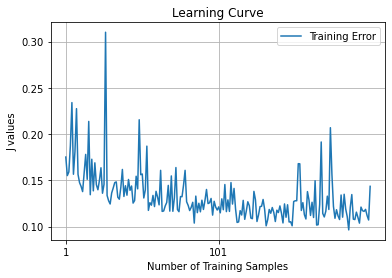

In [79]:
# Plot the learning curve
step_size = 10
plot_learning_curve(training_errors, step_size)